# Text Summarization with attention mechanism

In [36]:
import pandas as pd
import numpy as np
import re  # regular expression
import warnings
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
data = pd.read_csv(
    "../Dataset//amazon_reviews/Reviews.csv",
)
data.head()
data.info(
    verbose=True,
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## Explonatory data analysis and data preparation

We need to remove all duplicate sentences from the dataset.\
Remove and NA values from the dataset.

```python

In [3]:
data.drop_duplicates(subset=["Text"], inplace=True)  # drop duplicates
data.dropna(inplace=True)  # drop na values

data.info(
    verbose=True,
)

data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393565 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      393565 non-null  int64 
 1   ProductId               393565 non-null  object
 2   UserId                  393565 non-null  object
 3   ProfileName             393565 non-null  object
 4   HelpfulnessNumerator    393565 non-null  int64 
 5   HelpfulnessDenominator  393565 non-null  int64 
 6   Score                   393565 non-null  int64 
 7   Time                    393565 non-null  int64 
 8   Summary                 393565 non-null  object
 9   Text                    393565 non-null  object
dtypes: int64(5), object(5)
memory usage: 33.0+ MB


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data.tail(50)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
568379,568380,B000H28ABW,A1XVKAMXSOW8ZV,"C. E. Hunsicker ""Hatshepsut""",2,3,3,1256515200,Just OK,I hadn't tried this taco seasoning prior to pu...
568380,568381,B000H28ABW,A25RYX4NFWDJ2N,"Lyvonne Hipperling ""HEALTH ADVOCATE""",2,3,5,1181692800,HEALTHY EATING,THIS TACO SEASONING WAS RECOMMENDED TO ME AS A...
568381,568382,B000H28ABW,A1I44EGA0EDJ03,L. Woods,0,0,5,1351036800,Best taco seasoning you can buy,Notice that this taco seasoning packet weighs ...
568382,568383,B000H28ABW,A1TZXENU9QMGQE,nita,0,0,5,1350259200,Best buy 4 your money,I purchased a packet of the taco seasoning and...
568383,568384,B000H28ABW,A2RM8BU1FCYQM9,"Former Oak Parker ""music buff""",0,0,5,1324339200,Best Taco Seasoning EVER!!!,Wick Fowler Taco Seasoning is by far the best ...
568384,568385,B000H28ABW,A8T6W1M15FM75,"CA-SK ""CLA""",0,3,2,1255219200,Bland Taco Seasoning,"Tasteless, bland, insipid - how many synonyms ..."
568385,568386,B005OCX5XI,A6RFVZFCCPPAB,Sandra Thomas,1,1,1,1345507200,Rip-off: Be careful before u buy!!!!!!!,"Be very careful to check out the the oz size, ..."
568404,568405,B005OTVL8C,A1UJMVE0LCOI45,J. Wolf,0,0,5,1350172800,great flavor boost,If you want to add a hint of Meyer lemon flavo...
568405,568406,B000P56I7Y,A2ZKNGL20FBK2I,Shatzi Crabtree,3,5,5,1274918400,Arrived Fine,The product arrived pretty quickly and was eas...
568406,568407,B0039KE8Y2,A392FNHBJR1IY6,Leo Breeden,0,0,4,1336867200,great taste,This apple butter has a great taste but the pr...


#### Some words will be in its short form, which will not be recognized by algorithm. 
#### We will now replace these words by their exact form

In [5]:
contraction_mapping = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "this's": "this is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "here's": "here is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}


# copied from stackoverflow

In [6]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jeel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stop_words = set(stopwords.words("english"))


def text_cleaner(text, num):
    newString = text.lower()  # Convert everything to lowercase
    newString = re.sub("<[^<]+?>", "", newString)  # Remove HTML tags
    newString = re.sub(r"\([^)]*\)", "", newString)  # Remove parenthesis
    newString = re.sub('"', "", newString)  # Remove quotes
    newString = " ".join(
        [
            contraction_mapping[t] if t in contraction_mapping else t
            for t in newString.split(" ")
        ]
    )  # Contraction mapping
    newString = re.sub(r"'s\b", "", newString)  # Remove all 's
    newString = re.sub(
        "[^a-zA-Z]", " ", newString
    )  # remove all character except letters
    newString = re.sub("[m]{2,}", "mm", newString)  # remove all m's
    if num == 0:
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens = newString.split()
    long_words = []
    for i in tokens:
        if len(i) > 1:  # removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()


# using stackoverflow and regex documentation to clean the data

In [8]:
cleaned_text = []
for t in data["Text"]:
    cleaned_text.append(text_cleaner(t, 0))

In [9]:
cleaned_summary = []
for t in data["Summary"]:
    cleaned_summary.append(text_cleaner(t, 1))

In [10]:
cleaned_text[:10]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal',
 'got wild hair taffy ordered five pound bag taffy enjoyable many flavors watermelon root beer melon peppermint grape etc complaint bit much red black licorice flavored pieces kids husband l

In [11]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [12]:
data["cleaned_text"] = cleaned_text
data["cleaned_summary"] = cleaned_summary

In [13]:
# drop empty rows

data.replace("", np.nan, inplace=True)
data.dropna(axis=0, inplace=True)

### let's do some visualization of the data

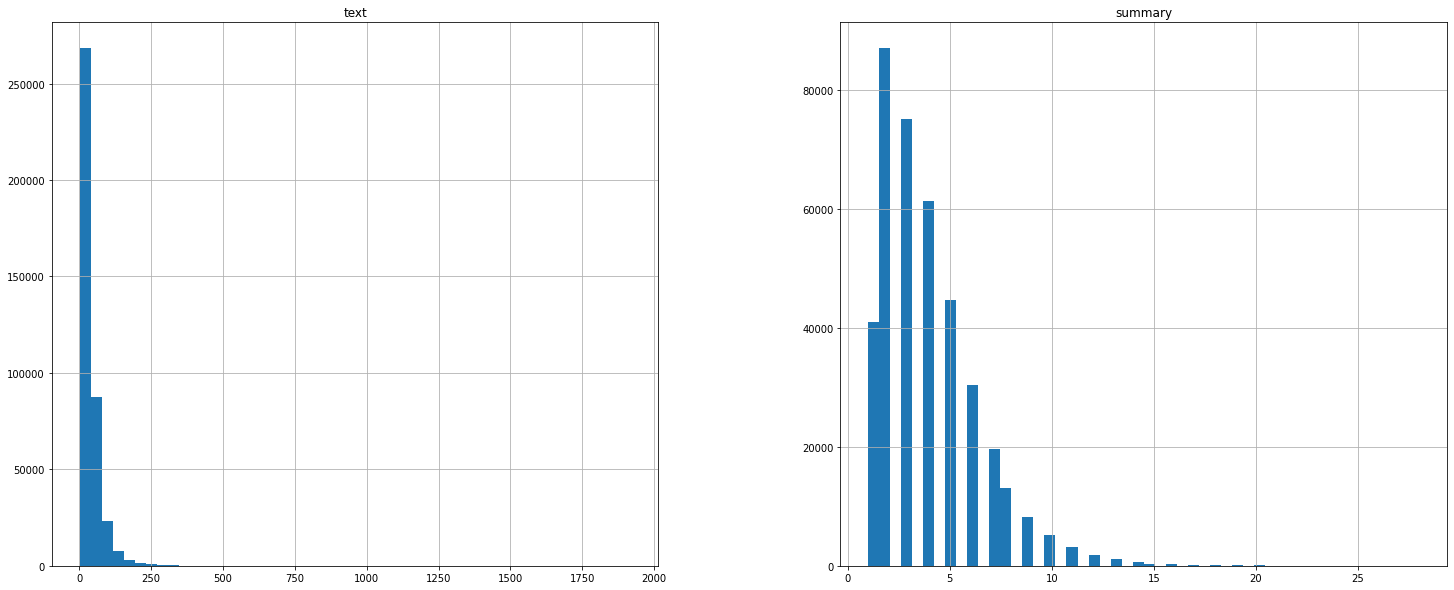

In [19]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data["cleaned_text"]:
    text_word_count.append(len(i.split()))

for i in data["cleaned_summary"]:
    summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({"text": text_word_count, "summary": summary_word_count})

length_df.hist(bins=50, figsize=(25, 10))

plt.show()

##### Since majority of text have maximum length 13 and majority of text have maximum length 30, we will fix these values as max length parameters

In [20]:
max_text_len = 30
max_summary_len = 8

In [21]:
cleaned_text = np.array(data["cleaned_text"])
cleaned_summary = np.array(data["cleaned_summary"])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if (
        len(cleaned_summary[i].split()) <= max_summary_len
        and len(cleaned_text[i].split()) <= max_text_len
    ):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df = pd.DataFrame({"text": short_text, "summary": short_summary})

df

,text,summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,looking secret ingredient robitussin believe f...,cough medicine
3,great taffy great price wide assortment yummy ...,great taffy
4,saltwater taffy great flavors soft chewy candy...,great just as good as the expensive brands
...,...,...
213760,complaint much use huge amount spice gave jar ...,very large ground spice jars
213761,great sesame chicken good better resturants ea...,will not do without
213762,disappointed flavor chocolate notes especially...,disappointed
213763,best treats training rewarding dog good groomi...,favorite training and reward treat


In [23]:
df["summary"] = df["summary"].apply(lambda x: "sos " + x + " eos")
df


,text,summary
0,bought several vitality canned dog food produc...,sos sos good quality dog food eos eos
1,product arrived labeled jumbo salted peanuts p...,sos sos not as advertised eos eos
2,looking secret ingredient robitussin believe f...,sos sos cough medicine eos eos
3,great taffy great price wide assortment yummy ...,sos sos great taffy eos eos
4,saltwater taffy great flavors soft chewy candy...,sos sos great just as good as the expensive br...
...,...,...
213760,complaint much use huge amount spice gave jar ...,sos sos very large ground spice jars eos eos
213761,great sesame chicken good better resturants ea...,sos sos will not do without eos eos
213762,disappointed flavor chocolate notes especially...,sos sos disappointed eos eos
213763,best treats training rewarding dog good groomi...,sos sos favorite training and reward treat eos...


In [35]:
stop_words = set(stopwords.words("english"))
x_tokenizer = Tokenizer()



def text_cleaner(text, num=0, max_text_len=30):
    newString = text.lower()  # Convert everything to lowercase
    newString = re.sub(r"\([^)]*\)", "", newString)
    newString = re.sub('"', "", newString)
    newString = " ".join(
        [
            contraction_mapping[t] if t in contraction_mapping else t
            for t in newString.split(" ")
        ]
    )  # Contraction mapping
    newString = re.sub(r"'s\b", "", newString)
    newString = re.sub(
        "[^a-zA-Z]", " ", newString
    )  # remove all character except latters
    newString = re.sub("[m]{2,}", "mm", newString)
    if num == 0:
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens = newString.split()
    long_words = []
    for i in tokens:
        if len(i) > 1:  # removing short word
            long_words.append(i)
    cleaned_text = (" ".join(long_words)).strip()

    cleaned_text = pd.DataFrame([cleaned_text])
    cleaned_text[0] = cleaned_text[0].apply(lambda x: "sos " + x + " eos")
    x_test_seq = x_tokenizer.texts_to_sequences(cleaned_text[0])

    return pad_sequences(x_test_seq, maxlen=max_text_len, padding="post")


NameError: name 'Tokenizer' is not defined

In [33]:
tex = 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo"'


In [34]:
t = text_cleaner(tex, num=0, max_text_len=30)
t



NameError: name 'x_tokenizer' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

# use 10% data for testing
x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(df["text"]),
    np.array(df["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,

In [ ]:

# prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))


In [ ]:
thresh = 4

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if value < thresh:
        cnt = cnt + 1
        freq = freq + value

print("% of rare words in vocabulary:", (cnt / tot_cnt) * 100)
print("Total Coverage of rare words:", (freq / tot_freq) * 100)


In [ ]:
# prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt - cnt)
x_tokenizer.fit_on_texts(list(x_tr))

# convert text sequences into integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# padding zero upto maximum length
x_tr = pad_sequences(x_tr_seq, maxlen=max_text_len, padding="post")
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding="post")

# size of vocabulary ( +1 for padding token)
x_voc = x_tokenizer.num_words + 1

In [ ]:
import pickle

with open("tokenizer.pkl", "wb") as fout:
    pickle.dump(x_tokenizer, fout)
